## Vector AutoRegressive Model for multiple time series

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

Some dataset columns are normalized as they contain large no.s of the order (10^12). They might skew the forecasting process.

In [119]:
df = pd.read_csv('/home/rishuu/sem5/DSc/final/prediction_data.csv', index_col = ['Year'])
# the datset is a time series.
df_c = df.copy()
df['GDP(current USD)'] /= 1e+12
df_c['GDP(current USD)'] /= 1e+12
data = df
data.dtypes

Inflation(CPI)                                float64
Export as % of GDP                            float64
Import as % of GDP                            float64
exchange rate                                 float64
Gross Domestic Capital Formation(% of GDP)    float64
GDP(current USD)                              float64
dtype: object

To check the stationarity in this time series we will use the Johansen cointegration test instead of Augmented dicky fuller test. ADF test can at max calculate the cointegration for two time series only while the johansen test can be used for a maximum of 12 time series. In our use case we have 6 time series.
Johansen test also doesn't depend on the order in which the time series variables are provided. ADF is order dependent.
If some of the eigenvalues contain negative values, it would imply that a linear combination of the time series can be created, which would result in stationarity.

In [120]:
# Checking stationarity of data
from statsmodels.tsa.vector_ar.vecm import coint_johansen
coint_johansen(data,0,1).eig

array([0.67248851, 0.49091829, 0.32902548, 0.23831661, 0.11981344,
       0.0361894 ])

In [121]:
train = data[:int(0.8*(len(data)))]
valid = data[int(0.8*(len(data))):]

In [122]:
from statsmodels.tsa.vector_ar.var_model import VAR
from sklearn.metrics import mean_squared_error

cols = data.columns

# fit the Var Model
model = VAR(endog=train)
model_fit = model.fit()

prediction = model_fit.forecast(model_fit.y, steps=len(valid))

# convert to pred.
pred = pd.DataFrame(index=range(0,len(prediction)),columns=[cols])
for j in range(0,len(cols)):
    for i in range(0, len(prediction)):
       pred.iloc[i][j] = prediction[i][j]

#check rmse
k = 0
for i in cols:
    print('rmse value for', i, 'is : ', (mean_squared_error(pred.iloc[:,k], valid[i]))**(0.5))
    k += 1
    
# make final predictions
model = VAR(endog=data)
model_fit = model.fit()
yhat = model_fit.forecast(model_fit.y, steps=10)
print(yhat)

rmse value for Inflation(CPI) is :  7.97717416641896
rmse value for Export as % of GDP is :  33.49672874751532
rmse value for Import as % of GDP is :  48.62016008413134
rmse value for exchange rate is :  31.89732824451433
rmse value for Gross Domestic Capital Formation(% of GDP) is :  72.89933756825266
rmse value for GDP(current USD) is :  1.3510636489993755
[[ 4.75606147e+00  1.96306174e+01  2.28889547e+01  7.11733390e+01
   2.89414146e+01  2.88891214e+00]
 [ 3.76112720e+00  1.91370292e+01  2.20030637e+01  7.38428891e+01
   2.72118306e+01  3.06339504e+00]
 [ 2.86687397e+00  1.84640200e+01  2.09703633e+01  7.64392757e+01
   2.55053838e+01  3.24578521e+00]
 [ 2.09570000e+00  1.76805004e+01  1.98361649e+01  7.90108316e+01
   2.37239975e+01  3.43475292e+00]
 [ 1.37408156e+00  1.68058474e+01  1.86055140e+01  8.15828691e+01
   2.18258303e+01  3.62975887e+00]
 [ 6.52472672e-01  1.58431627e+01  1.72721923e+01  8.41656955e+01
   1.97903034e+01  3.83055312e+00]
 [-9.38339987e-02  1.47898128e+01

/home/rishuu/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/rishuu/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


/home/rishuu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


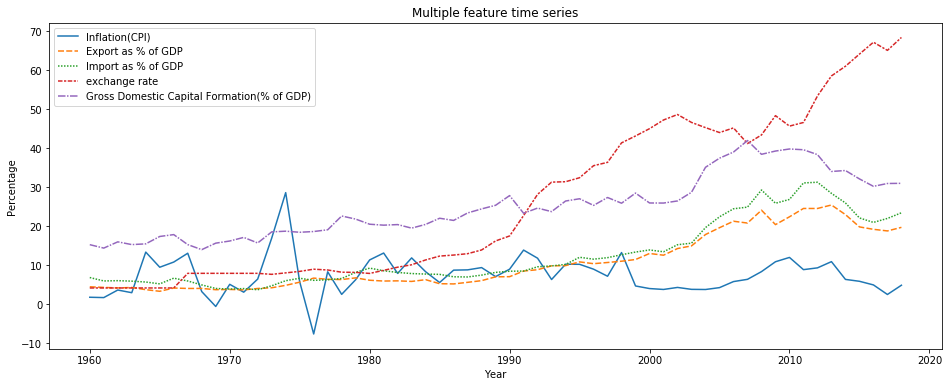

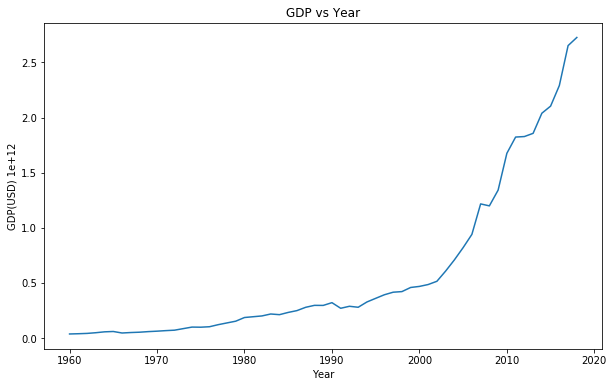

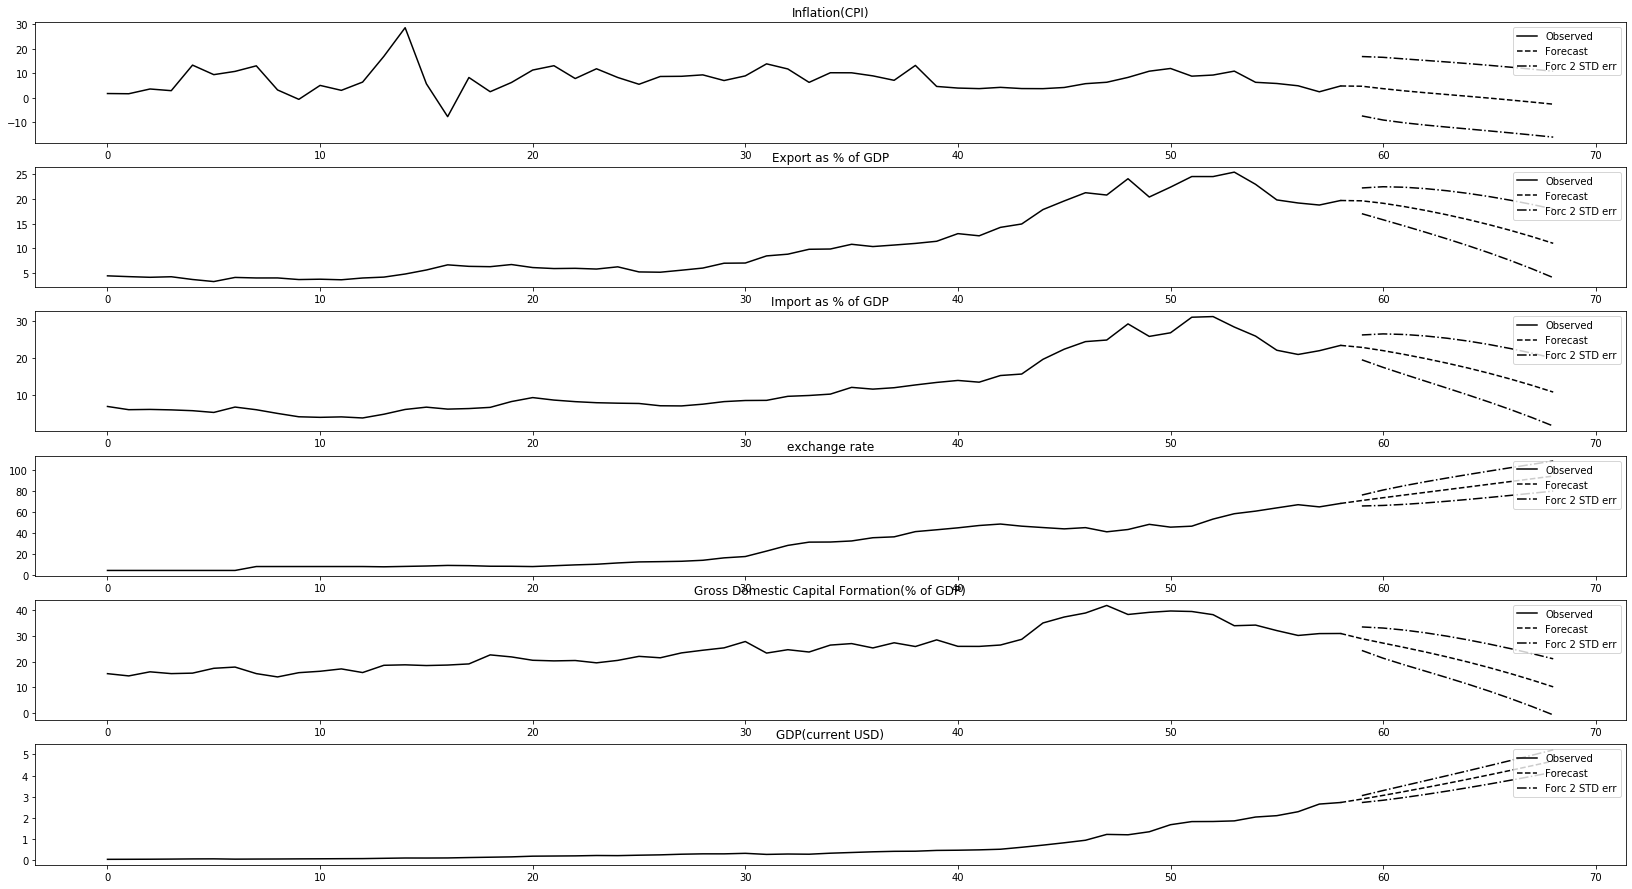

In [135]:
import seaborn as sns
import matplotlib.pyplot as plt

# del df_c['GDP(current USD)']
plt.figure(figsize=(16, 6))

plot1=sns.lineplot(data=data.iloc[:,:-1])
plot1.set(xlabel="Year", ylabel="Percentage", title="Multiple feature time series")

plt.figure(figsize=(10, 6))
plot1=sns.lineplot(data=data.iloc[:,-1])
plot1.set(xlabel="Year", ylabel="GDP(USD) 1e+12", title="GDP vs Year")


ab = model_fit.plot_forecast(10, alpha=0.01)
ab.set_size_inches(28.5, 15.5)
ab.show()
# now prediction augmented data.
index = list(range(10))
d = {'Inflation(CPI)' : yhat[:,0],
     'Export as % of GDP' : yhat[:,1],
     'Import as % of GDP' : yhat[:,2],
     'exchange rate' : yhat[:,3],
     'Gross Domestic Capital Formation(% of GDP)' : yhat[:,4],
     'GDP(current USD)' : yhat[:,5]}
ddf = pd.DataFrame(data = d, index=index)

## Causality hypothesis test

use : one can say that a set of variables are Granger-causal within one of the VAR equations.

In [144]:
model_fit.test_causality(['Inflation(CPI)', 'Export as % of GDP', 'Import as % of GDP', 'exchange rate', 'Gross Domestic Capital Formation(% of GDP)', 'GDP(current USD)'], 'GDP(current USD)' , kind='f').summary()

Test statistic,Critical value,p-value,df
486.7,2.128,0.000,"(6, 306)"
